# Modelo óptimo para la base de datos $California \,Housing$
### Andrés Nieto Guadarrama

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.compose
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,cross_validate
from sklearn.metrics import mean_squared_error
from ipywidgets import interact,interact_manual
from IPython.display import display
from numpy.random import seed, randn
from sklearn.preprocessing import PolynomialFeatures

In [62]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

### Base de datos: Casas en Seattle

In [93]:
housing=pd.read_csv(r"C:\Users\andre\OneDrive\Documentos\GitHub\Tareas_Diplomado\train.csv")

Crearemos un pipeline y limpiaremos la base convertiendo a variable categórica 'label_bin'.

### Modelo inicial

In [94]:
column_selector = ColumnTransformer(
    [("label_bin", OneHotEncoder(sparse=False), ["MSZoning", "SaleCondition"]),
     ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))]
)

pipe = Pipeline([
    ("select_cols", column_selector),
    ("lasso", Lasso(alpha=0.1, tol=0.5))
])

Tomemos una porción de los datos (20%) para probar el modelo, y el resto para entrenarlo

In [95]:
train, test = train_test_split(housing, test_size=0.2, random_state=2718)
xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]

cv = cross_validate(pipe, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]

Debemos mejorar la siguietne $R^2$:

In [96]:
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean MAE : {mae.mean():0.2f}")

mean r2: 0.44
mean MAE : 41749.60


In [67]:
from sklearn.model_selection import GridSearchCV

alphas = [1/i for i in range(1, 11)]
grid = {
    "lasso__alpha": [0.1 * 10 ** (i/2) for i in range(1, 11)],
}

In [68]:
%%time
gsearch = GridSearchCV(pipe, grid, scoring="neg_mean_absolute_error",
                       return_train_score=True, cv=10)
gsearch.fit(xtrain, ytrain)
cvres = gsearch.cv_results_

Wall time: 2.1 s


In [69]:
train_score = np.sqrt(-cvres["mean_train_score"])
test_score = np.sqrt(-cvres["mean_test_score"])

cv = cross_validate(gsearch.best_estimator_, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]

### A superar:

In [70]:
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean MAE : {mae.mean():0.2f}")

mean r2: 0.44
mean MAE : 41620.65


# Mejora del modelo inicial

### Exploración de datos

Exploremos un poco la relación entre las variables explicativas y la variable respuesta

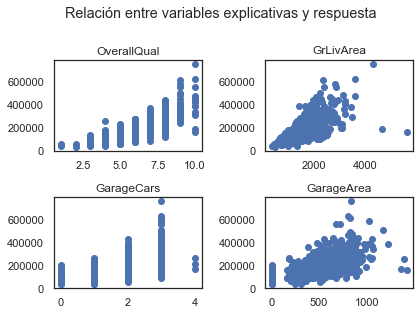

In [97]:
X=pd.concat([xtrain,ytrain],axis=1)
R2=X.corr()[list(X.keys())[-1]]
R2=R2.sort_values(ascending=False)
L=R2.index[1:5]
fig, ax = plt.subplots(2, 2)
plt.title('Window Title')
ax=ax.ravel()
for axi,l in zip(ax,L):
    axi.scatter(xtrain[l],ytrain)
    axi.set_title(l)
fig.suptitle('Relación entre variables explicativas y respuesta',y=1.09,x=.525)
plt.tight_layout()

In [79]:
X=pd.concat([xtrain,ytrain],axis=1)
R2=X.corr()[list(X.keys())[-1]]
R2=R2.sort_values(ascending=False)

### Matriz de varianzas y covarianzas

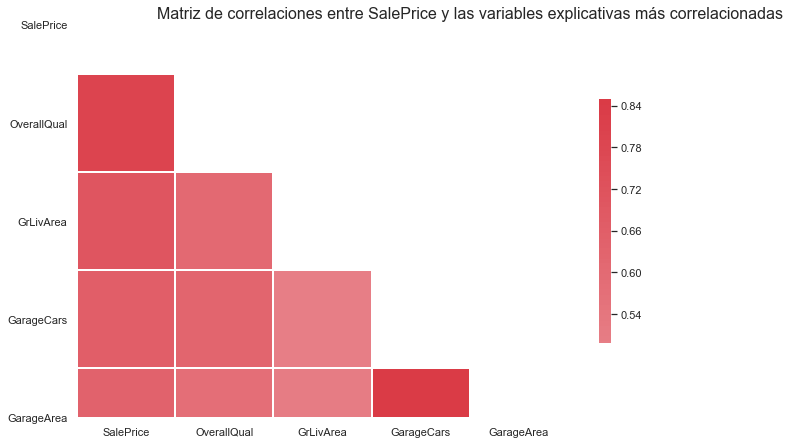

In [73]:
sns.set(style="white")
corr = X[R2.index[0:5]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(2200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.85, center=-.1,
            square=True, linewidths=1, cbar_kws={"shrink": .5})
plt.title("Matriz de correlaciones entre SalePrice y las variables explicativas más correlacionadas",fontsize=16,position=(.8,-300),va='baseline')
plt.yticks(rotation=0) 

plt.show()

### Modelo 1: Regresión polinomial

Proponemos una regresión polinomial entre la variable respuesta y GrLivArea, que es la columna con datos continuos para la que ytrain está más correlacionada.

In [80]:
import ipywidgets as widgets

def make_pipe(deg,x,y):
#     column_selector = ColumnTransformer([
#         ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"]),
#         ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        #("select_cols", column_selector),
        #("lasso", Lasso(alpha=0.1, tol=0.5)),
        ("Polytransform",PolynomialFeatures(degree=deg,include_bias=False)),
        ("linear_model",LinearRegression()),
    ])
    
    pipe.fit(x[:,np.newaxis],y)
    
    return pipe

def gbase(deg):
    X_exp=X[L[1]]
    x,y=X_exp,ytrain
    pipe=make_pipe(deg,x,y)
    rango_x=np.linspace(x.min(),x.max(),len(x))
    plt.title(f"Modelo polinomial de grado {deg}: Mejora el modelo inicial")
    plt.plot(rango_x,pipe.predict(rango_x.reshape(len(x),1)),c='r',label='modelo')
#     cv = cross_validate(pipe, x,y, cv=5, scoring=["r2", "neg_mean_absolute_error"])
#     r2 = cv["test_r2"]
#     mae = -cv["test_neg_mean_absolute_error"]

    r_cuad=pipe.score(np.array(x).reshape(len(x),1),np.array(y).reshape(len(x),1))
    plt.text(x=2250,y=125000,s=f"{'Coef. de determinación $R^2$'}: {round(100*r_cuad,2)}%")
#     plt.text(x=2250,y=125000,s=f"{'Coef. de determinación $R^2$'}: {round(r2.mean(),2)}")
    plt.legend()
    plt.show()

slider_deg=widgets.IntSlider(
    value=2,
    min=1,
    max=9,
    step=1,
    description='Grado:',
    height=5,
    width=5,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

w=interact_manual(gbase,deg=slider_deg) 
display(w)


interactive(children=(IntSlider(value=2, continuous_update=False, description='Grado:', max=9, min=1), Button(…

<function __main__.gbase(deg)>

### Modelo 1.5. Regresión polinomial con las dos variables que más correlacionadas están con el modelo

In [81]:
import ipywidgets as widgets

def make_pipe(deg,x,y):
    '''
    En este Pipeline enfocamos nuestro trabajo en 
    las variables continuas. Probaremos después un modelo con Lasso 
    y las variables categóricas.
    '''
#     column_selector = ColumnTransformer([
#         ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"]),
#         ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        #("select_cols", column_selector),
        #("lasso", Lasso(alpha=0.1, tol=0.5)),
        ("Polytransform",PolynomialFeatures(degree=deg,include_bias=False)),
        ("linear_model",LinearRegression()),
    ])
    
    pipe.fit(x,y[:,np.newaxis])
    
    return pipe

def gbase(deg):
    X_exp=X[[L[1],L[3]]]
    x,y=X_exp,ytrain
    pipe=make_pipe(deg,x,y)
    rango_x=np.linspace(y.min(),y.max(),len(y))
    plt.title(f"Modelo polinomial de grado {deg}: Mejora el modelo inicial")
    plt.scatter(rango_x,y[:,np.newaxis],c='b',label='observaciones')
    plt.scatter(rango_x,pipe.predict(np.array(x).reshape(len(x),2)),c='r',label='modelo')
#     cv = cross_validate(pipe, x,y, cv=5, scoring=["r2", "neg_mean_absolute_error"])
#     r2 = cv["test_r2"]
#     mae = -cv["test_neg_mean_absolute_error"]

    r_cuad=pipe.score(np.array(x).reshape(len(x),2),np.array(y).reshape(len(x),1))
    plt.text(x=2250,y=700000,s=f"{'Coef. de determinación $R^2$'}: {round(100*r_cuad,1)}%")
#     plt.text(x=2250,y=125000,s=f"{'Coef. de determinación $R^2$'}: {round(r2.mean(),2)}")
    plt.legend()
    plt.show()

slider_deg=widgets.IntSlider(
    value=2,
    min=1,
    max=9,
    step=1,
    description='Grado:',
    height=5,
    width=5,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

w=interact_manual(gbase,deg=slider_deg)
display(w)
print("Un modelo polinomial de grado 6 alcanza un coeficiente de determinación del 70% ")

interactive(children=(IntSlider(value=2, continuous_update=False, description='Grado:', max=9, min=1), Button(…

<function __main__.gbase(deg)>

Un modelo polinomial de grado 6 alcanza un coeficiente de determinación del 70% 


### Modelo 2. Uso de $\textit{Lasso}$

In [76]:
def make_pipe(x,y):
    '''
    Exploremos el modelo con las variables categóricas. 
    Veamos si el modelo mejora la transformación
    polinomial.
    '''
    column_selector = ColumnTransformer([
        ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"]),
        ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        ("select_cols", column_selector),
        ("lasso", Lasso(alpha=0.1, tol=0.5))
    ])
    
    pipe.fit(x,y[:,np.newaxis])
    
    return pipe

X_exp=X[L]
x,y=X_exp,ytrain
pipe=make_pipe(x,y)
cv = cross_validate(pipe, x, y, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
print(f"Coef. de determinación sólo con Lasso: {round(100*r2.mean(),1)}%")

gsearch = GridSearchCV(pipe, grid, scoring="neg_mean_absolute_error",return_train_score=True, cv=10)# mismos que el tamaño de Grid
gsearch.fit(x,y)
cvres = gsearch.cv_results_
train_score = np.sqrt(-cvres["mean_train_score"])
test_score = np.sqrt(-cvres["mean_test_score"])

cv = cross_validate(gsearch.best_estimator_, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
print(f"Coef. de determinación combinando GridSearch y Lasso: {round(100*r2.mean(),1)}%")

Coef. de determinación sólo con Lasso: 72.6%
Coef. de determinación combinando GridSearch y Lasso: 74.0%


Observar que el modelo de GridSearch combinado con Lasso mejoran el coeficiente de determinación del modelo. Veamos cómo mejora incluyendo árboles de decisión:

### Modelo 3. Clasificador con árboles de decisión

In [109]:
from sklearn.tree import DecisionTreeRegressor

x=X[[L[0],L[2]]]
y=X['SalePrice']
xtr, xte = train_test_split(x, test_size=0.3, random_state=314)
ytr, yte = train_test_split(y, test_size=0.3, random_state=314)

def make_pipe_tree(x,y,d):
    '''
    Exploremos el modelo con árboles de decisión
    '''
#     column_selector = ColumnTransformer([
#          ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"])])
         #("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
         #("select_cols", column_selector),
        ("tree", DecisionTreeRegressor(random_state=314,max_depth=d))
    ])
    
    pipe.fit(x,y)
    
    return pipe

depth=range(20,116,16)
for md in depth:
    regressor = make_pipe_tree(xtr,ytr,md)
    cv = cross_validate(regressor, xtr, ytr, cv=5, scoring=["r2"])
    r2 = cv["test_r2"]
    print(f"Coef. de determinación usando árboles de decisión: {round(100*r2.mean(),1)}% con profundidad de {md}.")

Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 20.
Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 36.
Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 52.
Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 68.
Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 84.
Coef. de determinación usando árboles de decisión: 74.8% con profundidad de 100.


### 4. Modelos finales: Boosting

Usando las variables más correlacionadas, un modelo de árboles de decisión mejora un poco el coeficiente de determinación respecto a los otros. Veamos si podemos potenciar este resultado con métodos de boosting.

### 4.1 Usando Bosques

In [126]:
from sklearn.ensemble import RandomForestRegressor

def make_pipe_forest(x,y):
    '''
    Exploremos el modelo con árboles de decisión
    '''
    column_selector = ColumnTransformer([
         ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"]),
         ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        ("select_cols", column_selector),
        ("forest", RandomForestRegressor(n_estimators=400, random_state=314, n_jobs=-1, oob_score=True))
    ])
    
    pipe.fit(x,y)
    return pipe 

#rf = RandomForestRegressor(n_estimators=400, random_state=314, n_jobs=-1, oob_score=True)
X_exp=X[L]
x,y=X_exp,ytrain
rf=make_pipe_forest(x,y)
cv = cross_validate(rf, x,y, cv=5, scoring=["r2"])
r2=cv["test_r2"]
print(f"Coef. de determinación usando bosques: {round(100*r2.mean(),1)}%.")

Coef. de determinación usando bosques: 72.9%.


### 4.2 Usando Bagging

In [131]:
from sklearn.ensemble import BaggingRegressor

def make_pipe_bag(x,y):
    '''
    Exploremos el modelo con árboles de decisión
    '''
    column_selector = ColumnTransformer([
         ("label_bin", OneHotEncoder(sparse=False), ["OverallQual", "GarageCars"]),
         ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        ("select_cols", column_selector),
        ("bagging", BaggingRegressor(DecisionTreeRegressor(random_state=314,max_depth=20),n_estimators=500,bootstrap=True, max_samples=100, n_jobs=-1))
    ])
    
    pipe.fit(x,y)
    return pipe 

#rf = RandomForestRegressor(n_estimators=400, random_state=314, n_jobs=-1, oob_score=True)
X_exp=X[L]
x,y=X_exp,ytrain
bag=make_pipe_bag(x,y)
cv = cross_validate(rf, x,y, cv=5, scoring=["r2"])
r2=cv["test_r2"]
print(f"Coef. de determinación usando bagging: {round(100*r2.mean(),1)}%.")

Coef. de determinación usando bagging: 72.9%.


### 4.3 Usando Voting

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor

def make_pipe():
    column_selector = ColumnTransformer([
        ("label_bin", OneHotEncoder(sparse=False), ["OverallQual"]),
        ("numeric", SimpleImputer(), make_column_selector(dtype_include="float"))])

    pipe=Pipeline([
        ("select_cols", column_selector),
        ("linear_model",LinearRegression()),
    ])
    
    return pipe

tree = DecisionTreeRegressor(random_state=314,max_depth=20)

clf = VotingRegressor([
    ("reg", make_pipe()),
    ("tree", tree)])

models=[make_pipe(),tree,clf]
names="Regresion_lineal,Arboldecision,Votos".split(",")
for model,n in zip(models,names):
    if name=='Regresion_lineal':
        X_exp=X[L[0]]
        x,y=X_exp,ytrain
        model.fit(x,y)
    else:
        X_exp=X[L]
        x,y=X_exp,ytrain
        model.fit(x,y)
    cv = cross_validate(model,x,y, cv=5, scoring=["r2"])
    r2=cv["test_r2"]
    print(f"Modelo:{n} R^2:{round(100*r2.mean(),2)}")

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found unknown categories [1] in column 0 during transform

  FitFailedWarning)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found unknown categories [1] in column 0 during transform

  FitFailedWarning)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found unknown categories [2] in column 0 during transform

  FitFailedWarning)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_validati

Modelo:Grid R^2:nan
